In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1. Importing and visualising data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
merged = pd.concat([train, test], sort=False)

print(f"Train: {train.shape}, Test: {test.shape}")
train.head()

Train: (891, 12), Test: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


**Quick visualisation**

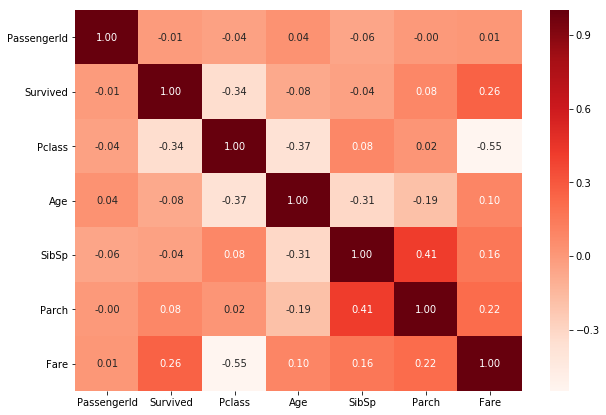

In [4]:
fig = plt.figure(figsize=(10, 7))
sns.heatmap(train.corr(), annot=True, fmt=".2f", cmap='Reds');

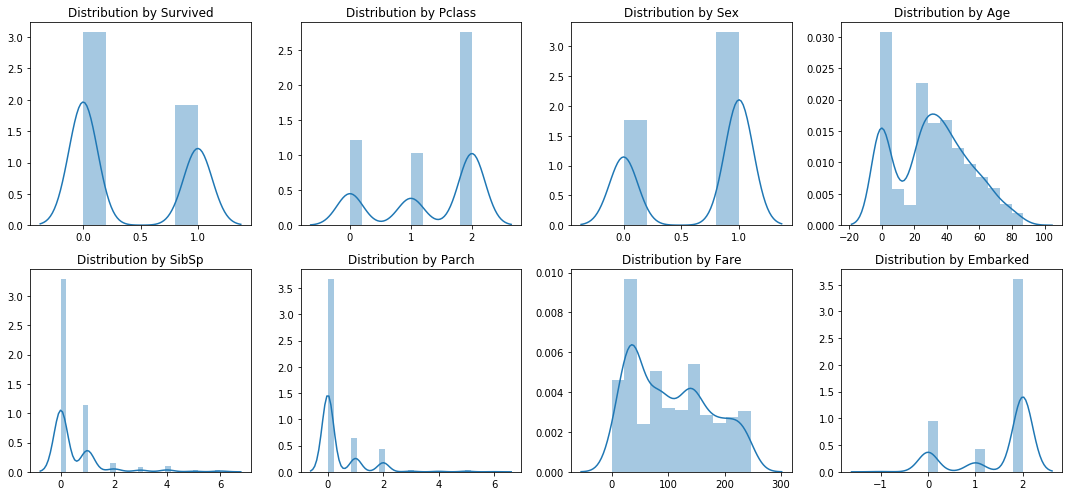

In [5]:
fig = plt.figure(figsize=(15, 7))

for i, col in enumerate(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']):
    plt.subplot(2,4,i+1)
    sns.distplot(train[col].astype('category').cat.codes)
    plt.title(f'Distribution by {col}');
plt.tight_layout()

**`Sex` and `Age`**

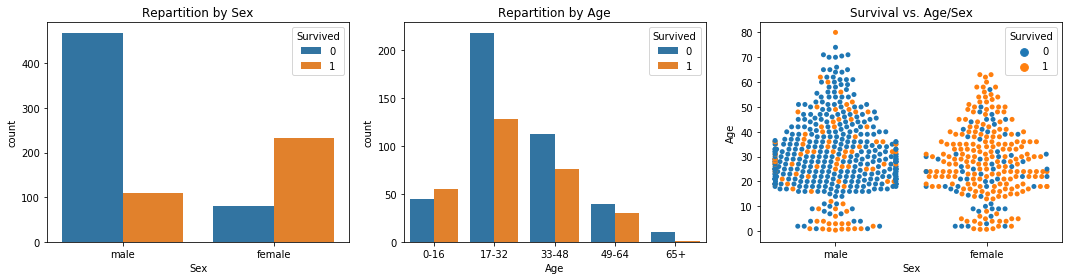

In [6]:
fig = plt.figure(figsize=(15, 4))

plt.subplot(131)
sns.countplot('Sex', data=train, hue='Survived')
plt.title('Repartition by Sex');

plt.subplot(132)
age_cat = pd.cut(train.Age, 5, labels=['0-16', '17-32', '33-48', '49-64', '65+'])
sns.countplot(age_cat, data=train, hue='Survived')
plt.title('Repartition by Age');

plt.subplot(133)
sns.swarmplot(x='Sex', y='Age', data=train, hue='Survived')
plt.title('Survival vs. Age/Sex');
plt.tight_layout()

**`Fare` and `Pclass`**

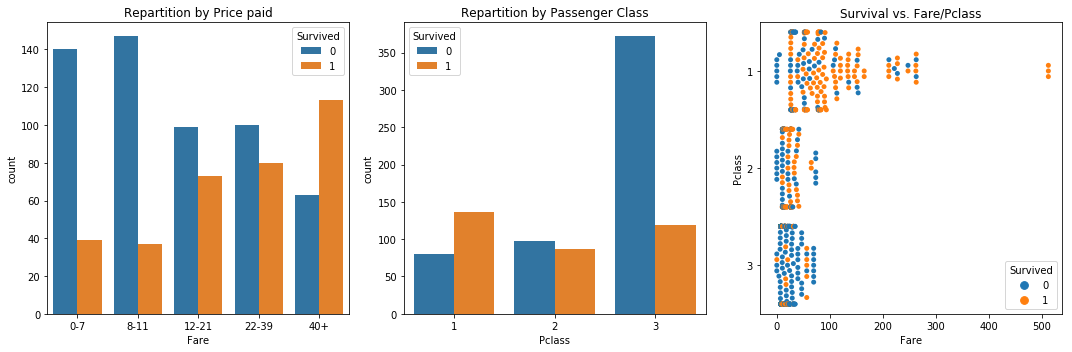

In [7]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(131)
fare_cat = pd.qcut(train.Fare, 5, labels=['0-7', '8-11', '12-21', '22-39', '40+'])
sns.countplot(fare_cat, data=train, hue='Survived')
plt.title('Repartition by Price paid');

plt.subplot(132)
sns.countplot('Pclass', data=train, hue='Survived')
plt.title('Repartition by Passenger Class');

plt.subplot(133)
sns.swarmplot(x='Fare', y='Pclass', data=train, hue='Survived', orient='h')
plt.title('Survival vs. Fare/Pclass');
plt.tight_layout()

# 2. Creating new features, and dealing with missing data

**`Embarked` and `Fare`**  
Fill missing data with most frequent values, using `mode`.


In [8]:
merged.Embarked.fillna(merged.Embarked.mode().item(), inplace=True)
merged.Fare.fillna(float(merged.Fare.mode()), inplace=True)

**`Name`**  
Extract passenger's Title from their Name, and replace rare titles with either `Mr`, `Mrs` or `Ms`.

In [9]:
merged['Title'] = merged.Name.apply(lambda x: x.split(',')[1].split('.')[0]).str.strip()
merged.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Ms                2
Major             2
Lady              1
Sir               1
the Countess      1
Mme               1
Don               1
Jonkheer          1
Dona              1
Capt              1
Name: Title, dtype: int64

In [10]:
merged.Title = np.where(merged.Title.isin(['Major',
                                           'Sir', 
                                           'Don', 
                                           'Jonkheer', 
                                           'Capt',
                                           'Col']), 'Mr', merged.Title)

merged.Title = np.where(merged.Title.isin(['Lady', 
                                           'the Countess', 
                                           'Dona']), 'Mrs', merged.Title)

merged.Title = np.where(merged.Title.isin(['Mlle', 
                                           'Mme', 
                                           'Ms']), 'Miss', merged.Title)

In [11]:
merged.Title.value_counts()

Mr        767
Miss      265
Mrs       200
Master     61
Dr          8
Rev         8
Name: Title, dtype: int64

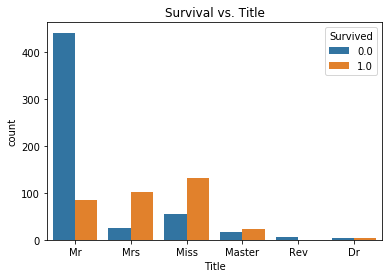

In [12]:
sns.countplot('Title', data=merged, hue='Survived')
plt.title('Survival vs. Title');

**`Age`**  
Impute missing values depending on median age for a given Title (e.g. `Master` represents young boys)

In [13]:
for title in merged.Title.unique():
    merged.Age = np.where(merged.Age.isnull() & merged.Title.isin([title]), 
                          merged.groupby('Title').Age.median()[title],
                          merged.Age)

**`SibSp` and `Parch`**  
Combine those features into a new one (`Family_size`) and cut it into groups.

In [14]:
merged['Family_size'] = merged.SibSp + merged.Parch + 1
merged.Family_size = pd.cut(merged.Family_size, 
                            [0, 1, 2, 4, np.inf], 
                            labels=['Solo', 'Duo', 'Small Family', 'Large Family']
                           )

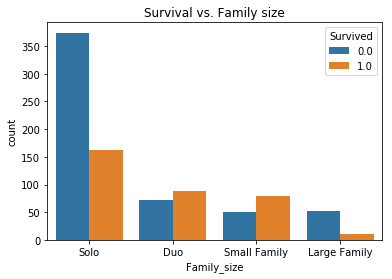

In [15]:
sns.countplot('Family_size', data=merged, hue='Survived')
plt.title('Survival vs. Family size');

**`Ticket` and `Cabin`**  
Replace those features with the Ticket prefix, and the Cabin letter identifier, since they might give valuable information about passenger localization on board.

In [16]:
cabin_letters = merged.Cabin.apply(lambda x: str(x).split()[0][0])
merged.Cabin = np.where(~merged.Cabin.isnull(), cabin_letters, 'U')
merged.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family_size
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,Mr,Duo
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs,Duo
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Miss,Solo
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs,Duo
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,Mr,Solo


In [17]:
merged.Ticket = merged.Ticket.apply(
    lambda x: str(x).split()[0].strip() if not 
    str(x).isnumeric() else 
    'U')

Remove rare ticket prefixes

In [18]:
merged.Ticket.nunique()

51

In [19]:
rare_prefixes = ['WE/P', 'W.E.P.', 'SC', 'P/PP', 'W/C', 'SC/A.3', 'AQ/3.', 'AQ/4', 'S.P.',
                 'SO/C', 'A4.', 'S.O.P.', 'S.C./A.4.', 'STON/OQ.', 'C.A./SOTON', 'Fa',
                 'SW/PP', 'A.', 'LP', 'S.W./PP', 'A/S', 'SC/A4', 'SCO/W']
merged.Ticket = np.where(merged.Ticket.isin(rare_prefixes), 'U', merged.Ticket)

In [20]:
merged.Ticket.value_counts()

U             984
PC             92
C.A.           46
SOTON/O.Q.     16
STON/O         14
W./C.          14
CA.            12
A/5            12
SC/PARIS       11
CA             10
A/5.           10
F.C.C.          9
SOTON/OQ        8
C               8
S.O./P.P.       7
STON/O2.        7
S.O.C.          7
A/4             6
SC/AH           5
SC/Paris        5
LINE            4
PP              4
A.5.            3
F.C.            3
S.C./PARIS      3
A./5.           3
A/4.            3
SOTON/O2        3
Name: Ticket, dtype: int64

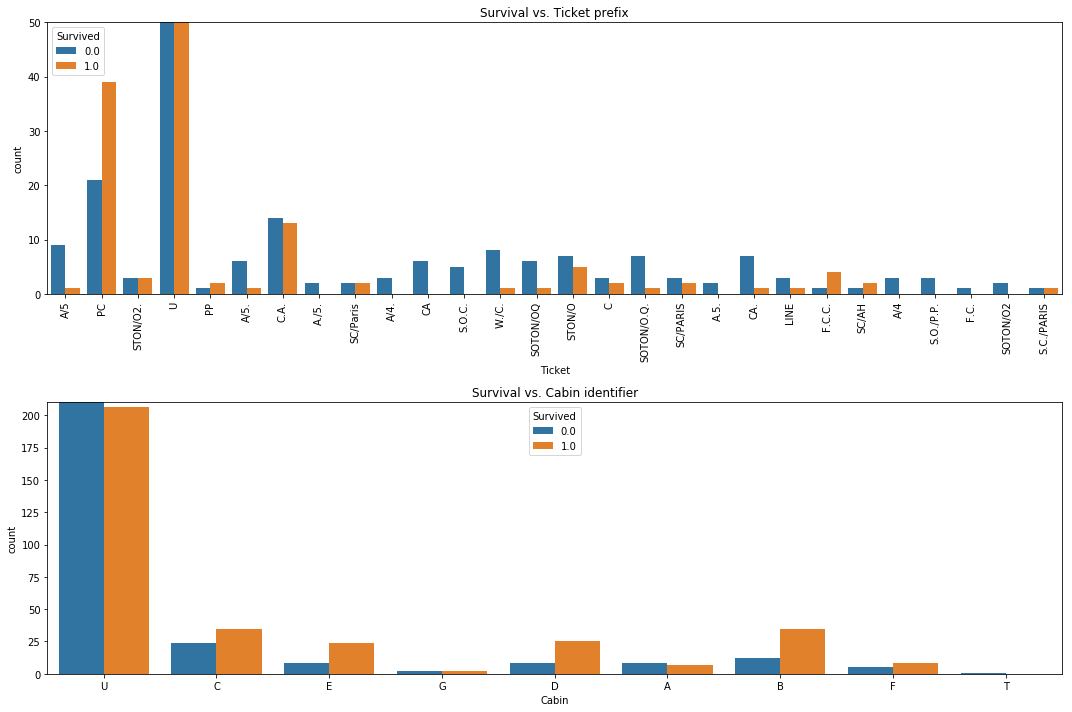

In [21]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(211)
sns.countplot('Ticket', data=merged, hue='Survived')
plt.ylim(0,50)
plt.xticks(rotation='vertical')
plt.title('Survival vs. Ticket prefix');

plt.subplot(212)
sns.countplot('Cabin', data=merged, hue='Survived')
plt.ylim(0,210)
plt.title('Survival vs. Cabin identifier');
plt.tight_layout()

# 3. Cleaning up and categorising data

**Categorizing `Sex`, `Age` and `Fare`**

In [22]:
merged['Is_female'] = np.where(merged.Sex == 'female', 1, 0)

In [23]:
age_bins = [0, 14, 23, 33, 60, np.inf]
merged['Age_group'] = pd.cut(merged.Age, age_bins)

In [24]:
merged['Fare_group'] = pd.qcut(merged.Fare, 5)

In [25]:
for i in ['Fare_group', 'Age_group', 'Family_size']:
    merged[i] = merged[i].astype('category').cat.codes + 1

**Generating dummies for categories containing unordered labels**

In [26]:
to_dumm = ['Embarked', 'Cabin', 'Ticket', 'Title']
for i in to_dumm:
    merged = pd.concat([merged, pd.get_dummies(merged[i], prefix=i)], axis=1)

**Dropping columns that are not useful anymore**

In [27]:
merged.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Family_size',
       'Is_female', 'Age_group', 'Fare_group', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U', 'Ticket_A./5.',
       'Ticket_A.5.', 'Ticket_A/4', 'Ticket_A/4.', 'Ticket_A/5', 'Ticket_A/5.',
       'Ticket_C', 'Ticket_C.A.', 'Ticket_CA', 'Ticket_CA.', 'Ticket_F.C.',
       'Ticket_F.C.C.', 'Ticket_LINE', 'Ticket_PC', 'Ticket_PP',
       'Ticket_S.C./PARIS', 'Ticket_S.O./P.P.', 'Ticket_S.O.C.',
       'Ticket_SC/AH', 'Ticket_SC/PARIS', 'Ticket_SC/Paris',
       'Ticket_SOTON/O.Q.', 'Ticket_SOTON/O2', 'Ticket_SOTON/OQ',
       'Ticket_STON/O', 'Ticket_STON/O2.', 'Ticket_U', 'Ticket_W./C.',
       'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Rev'],
      dtype='object')

In [28]:
to_drop = ['Name', 'SibSp', 'Parch', 'Sex', 'Cabin', 'Embarked', 'Ticket', 'Fare', 'Age', 'Title', 'PassengerId']
merged.drop(to_drop, axis = 1, inplace = True)

In [31]:
merged.head()

,Survived,Pclass,Family_size,Is_female,Age_group,Fare_group,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,...,Ticket_STON/O,Ticket_STON/O2.,Ticket_U,Ticket_W./C.,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,0.0,3,2,0,2,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1.0,1,2,1,4,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.0,3,1,1,3,2,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
3,1.0,1,2,1,4,5,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4,0.0,3,1,0,4,2,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


# 4. Modelling

**Creating variables, splitting training set into train + validation sets**

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
train_df = merged[~merged.Survived.isnull()]
X_test = merged[merged.Survived.isnull()]
X_test.drop('Survived', inplace=True, axis=1)


In [45]:
X = train_df.drop('Survived', axis=1)
y = train_df.Survived

In [46]:
(X_train, X_val, 
 y_train, y_val) = train_test_split(X, y, test_size=0.2)

In [47]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

(712, 51) (712,)
(179, 51) (179,)
(418, 51)


## a/ Random forests

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
rf = RandomForestClassifier(n_estimators=1000, bootstrap=True, oob_score=True, n_jobs=-1)
rf.fit(X_train,y_train);

In [49]:
def print_score(m):
    print(f'* {m.__class__.__name__} *')
    print(f"Train R^2: {m.score(X_train, y_train)}")
    print(f"Valid R^2: {m.score(X_val, y_val)}")
    if hasattr(m, 'oob_score_'): 
        print(f"OOB: {m.oob_score_}")

In [53]:
print_score(rf)

* RandomForestClassifier *
Train R^2: 0.9241573033707865
Valid R^2: 0.8547486033519553
OOB: 0.8075842696629213


**Plotting feature importance**

In [54]:
def rf_feat_importance(m, df):
    return pd.DataFrame({
        'cols':df.columns, 
        'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [88]:
def plot_fi(fi): 
    return fi.plot('cols', 
                   'imp', 
                   'barh', 
                   figsize=(12,7), 
                   legend=False,
                   title='Feature importances')

In [89]:
fi = rf_feat_importance(rf, X_train); fi[:10]

,cols,imp
48,Title_Mr,0.132593
4,Fare_group,0.121445
3,Age_group,0.112694
2,Is_female,0.111464
1,Family_size,0.097085
0,Pclass,0.079208
47,Title_Miss,0.048503
16,Cabin_U,0.042268
49,Title_Mrs,0.037960
43,Ticket_U,0.019657


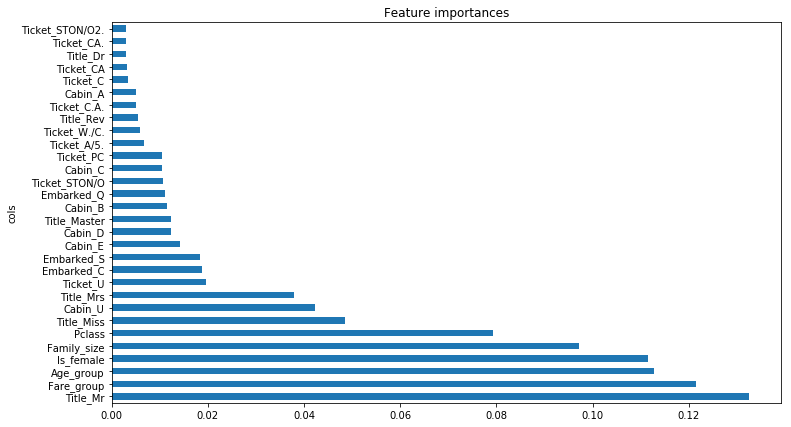

In [90]:
plot_fi(fi[:30])

**Plotting feature correlation**  
Are different features measuring the same thing?

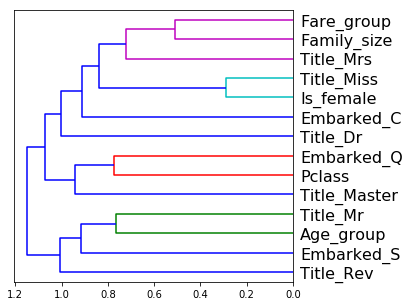

In [79]:
from scipy.cluster import hierarchy as hc
from scipy.stats import spearmanr

XX = X_train.copy()
column_filter = [col for col in XX if not (col.startswith('Ticket') or col.startswith('Cabin'))]
corr = np.round(spearmanr(XX[column_filter]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(5,5))
dendrogram = hc.dendrogram(z, labels=columns, orientation='left', leaf_font_size=16)
plt.show()

In [ ]:
BREAK

**Interpreting decision trees**  
Understanding how decision trees reach their predictions depending on features

In [111]:
from treeinterpreter import treeinterpreter as ti
import waterfall_chart

In [140]:
def plot_contrib(df, row, threshold=None):
    pred, bias, contrib = ti.predict(m, df)
    pred = pred[:,1].reshape(-1,1)
    contrib = contrib[:,:,1]
    
    idxs = np.argsort(contrib[row])
    lst = [o for o in zip(df.columns[idxs], df.iloc[row][idxs], contrib[row][idxs])]
    
    for tup in lst:
        if threshold:
            if np.abs(tup[2]) > threshold:
                print(tup)
        else:
            print(tup)
    
    a = [tup[0] for tup in lst]
    b = [tup[2] for tup in lst]
    contrib_plot = waterfall_chart.plot(a, b, threshold=threshold, other_label='misc.');
    contrib_plot.xticks(rotation=90);
    print(f"Prediction: {pred[row].item()}. Survived: {pred[row].item()>=0.5}")

('Title_Miss', 0, -0.01271879680329551)
('Family_size', 2, 0.030106490013765776)
('Fare_group', 5, 0.05611059012615194)
('Pclass', 1, 0.07844361826501857)
('Cabin_U', 0, 0.08687085696267377)
('Title_Mrs', 1, 0.11369701630527464)
('Title_Mr', 0, 0.11751776883243607)
('Is_female', 1, 0.13313239996731516)
Prediction: 0.9988095238095238. Survived: True


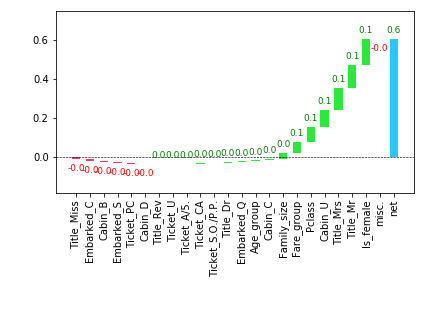

In [145]:
plot_contrib(X, 3, threshold=0.01)

('Cabin_C', 1, -0.14381737580491083)
('Title_Mr', 1, -0.10524799817681063)
('Is_female', 0, -0.08394652878307522)
('Cabin_D', 0, -0.04205533411913416)
('Ticket_U', 0, -0.04181619372024391)
('Cabin_B', 0, -0.04004659184304889)
('Cabin_A', 0, -0.03012337599934315)
('Title_Miss', 0, -0.029069978209374406)
('Title_Mrs', 0, -0.028879972939697046)
('Cabin_E', 0, -0.016828087564044407)
('Embarked_S', 0, 0.016136852293933666)
('Embarked_C', 1, 0.03256950515178395)
('Fare_group', 5, 0.05339187787746403)
('Pclass', 1, 0.055691641787818186)
('Cabin_U', 0, 0.11539882457810816)
Prediction: 0.09084166666666668. Survived: False


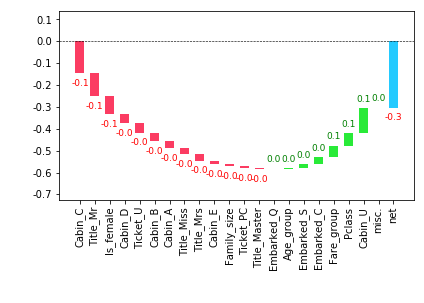

In [144]:
plot_contrib(X, 544, threshold=0.01)

**Tuning Random Forest hyperparameters with Grid Search**

In [146]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import forest

# Setting maximum number of examples to take as inputs for any given tree
# (Sk-learn takes all examples)
def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [147]:
def do_gs():    
    rf = RandomForestClassifier(max_features='auto', 
                                oob_score=True, 
                                n_jobs=-1)
    param_grid = { 
        "min_samples_leaf" : [1, 5], 
        "min_samples_split" : [2, 6, 10, 15], 
        "n_estimators": [50, 100, 500, 1000],
        "max_features": [0.2, 0.5, 0.8, None],
        }
    gs = GridSearchCV(estimator=rf,
                      param_grid=param_grid, 
                      scoring='f1',
                      cv=4,
                      n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print(gs.best_score_)
    print(gs.best_params_)
    print(gs.best_estimator_)
    print_score(gs.best_estimator_)

Running GS taking different amounts of examples at a time

In [148]:
for samples in [100, 250, 500, 'full']:
    print()
    print(f'------{samples}------')
    if samples != 'full':
        set_rf_samples(samples)
        do_gs()
        reset_rf_samples()
    else:
        reset_rf_samples()
        do_gs()
        print()
        print(f'------done------')


------100------
0.7762551038098483
{'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
* RandomForestClassifier *
Train R^2: 0.8553370786516854
Valid R^2: 0.8547486033519553
OOB: 0.824438202247191

------250------
0.7776237918683859
{'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1000}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples

**Generating predictions**

In [149]:
def write_pred(model):
    name = input("Filename? > ")
    raw = pd.read_csv("test.csv")
    predictions = pd.concat([
        raw["PassengerId"], 
        pd.Series(model.predict(X_test).astype('int'), name="Survived")
        ], axis=1)
    predictions.to_csv(f"{name}.csv", index=False)

With 100 samples per tree:

In [152]:
set_rf_samples(100)
rf_100 = RandomForestClassifier(
    **{'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100},
    bootstrap=True, 
    oob_score=True, 
    n_jobs=-1
    )
rf_100.fit(X, y)
print_score(rf_100)

* RandomForestClassifier *
Train R^2: 0.8567415730337079
Valid R^2: 0.8770949720670391
OOB: 0.8294051627384961


In [153]:
write_pred(rf_100)

Filename? > new_rf_100


***This gets a score of `0.79904` on Kaggle.***

Running again with more estimators:

In [157]:
set_rf_samples(100)
rf_100_1000est = RandomForestClassifier(
    **{'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000},
    bootstrap=True, 
    oob_score=True, 
    n_jobs=-1
    )
rf_100_1000est.fit(X, y)
print_score(rf_100_1000est)

* RandomForestClassifier *
Train R^2: 0.8567415730337079
Valid R^2: 0.8715083798882681
OOB: 0.8383838383838383


In [158]:
write_pred(rf_100_1000est)

Filename? > new_rf_100_1000est


***Scored only `0.78468`. More estimators is not always better...***

With full samples for each tree:

In [154]:
reset_rf_samples()
rf_all = RandomForestClassifier(
    **{'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000},
    bootstrap=True, 
    oob_score=True, 
    n_jobs=-1
    )
rf_all.fit(X, y)
print_score(rf_all)

* RandomForestClassifier *
Train R^2: 0.8834269662921348
Valid R^2: 0.8994413407821229
OOB: 0.8294051627384961


In [155]:
write_pred(rf_all)

Filename? > new_rf_all


***This gets a score of `0.79425` on Kaggle.***

## b/ Gradient boosting

In [159]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=1000)
gb.fit(X_train, y_train)
print_score(gb)

* GradientBoostingClassifier *
Train R^2: 0.9185393258426966
Valid R^2: 0.8491620111731844


**Plotting influence of n_estimators on model accuracy**

In [167]:
from math import sqrt
def mse(x,y): 
    mean_diff = ((x-y)**2).mean()
    return mean_diff

In [180]:
def plot_eval_graph(mini, maxi, step):
    train_errs = []
    val_errs = []
    classifiers = []
    for i in range(mini, maxi+1, step):
        m = GradientBoostingClassifier(n_estimators=i, learning_rate=0.001)
        m.fit(X_train, y_train)
        train_err = mse(m.predict(X_train), y_train)
        val_err = mse(m.predict(X_val), y_val)
        train_errs.append(train_err)
        val_errs.append(val_err)
    plt.plot(list(range(mini, maxi+1, step)), train_errs)
    plt.plot(list(range(mini, maxi+1, step)), val_errs)

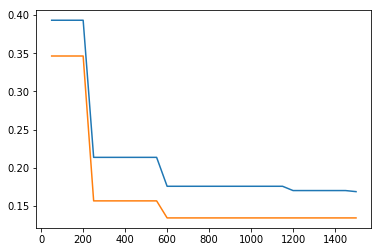

In [181]:
plot_eval_graph(50,1500,50)

In [190]:
def plot_learning_curve():
    train_errs = []
    val_errs = []
    classifiers = []
    lst = [0.001, 0.003, 0.007, 
           0.01, 0.03, 0.07,
           0.1, 0.3, 0.7,
           1, 10]
    for rate in lst:
        m = GradientBoostingClassifier(n_estimators=500, learning_rate=rate)
        m.fit(X_train, y_train)
        train_err = mse(m.predict(X_train), y_train)
        val_err = mse(m.predict(X_val), y_val)
        train_errs.append(train_err)
        val_errs.append(val_err)
    plt.plot(train_errs)
    plt.plot(val_errs)

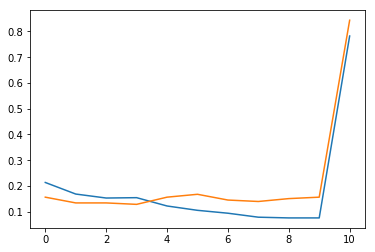

In [191]:
plot_learning_curve()

**Tuning Gradient Boosting hyperparameters with Grid Search**

In [160]:
def do_gs():    
    gb = GradientBoostingClassifier()
    param_grid = { 
        "max_depth": [3, 5],
        "min_samples_split" : [2, 6, 10], 
        "learning_rate": [0.05, 0.01, 0.001],
        "max_features": [0.5, None],
        "n_estimators": [500, 1000, 2000, 5000]
        }
    gs = GridSearchCV(estimator=gb,
                      param_grid=param_grid, 
                      scoring='f1',
                      cv=4,
                      n_jobs=-1)
    gs = gs.fit(X, y)
    print(gs.best_score_)
    print(gs.best_params_)
    print(gs.best_estimator_)
    print_score(gs.best_estimator_)

In [161]:
do_gs()

/Users/omega/.virtualenvs/fastai/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7706938254413002
{'learning_rate': 0.001, 'max_depth': 5, 'max_features': None, 'min_samples_split': 10, 'n_estimators': 5000}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=5000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
* GradientBoostingClassifier *
Train R^2: 0.8820224719101124
Valid R^2: 0.8938547486033519


**Generating predictions**

In [163]:
best_gb = GradientBoostingClassifier(**{
    'learning_rate': 0.001, 
    'max_depth': 5, 
    'max_features': None, 
    'min_samples_split': 10, 
    'n_estimators': 5000}
    )
best_gb.fit(X, y)
print_score(best_gb)

* GradientBoostingClassifier *
Train R^2: 0.8820224719101124
Valid R^2: 0.8938547486033519


In [164]:
write_pred(best_gb)

Filename? > new_gb


***This gets a score of `0.80861` on Kaggle.***  
***TOP 8%***